# Fullruns
### A notebook for exploring and comparing two new full transient CESM1 21st century/1850 runs featuring all previous COSP fields, with and without land-sea discriminations.
##### Initialized by Drew Camron 07/2018
---

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np

from pyresample import geometry, image

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='poster')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:60398 Dashboard: http://127.0.0.1:45931/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


Jen has provided these two CESM1 + COSP1.4 runs, each ~100 years with all of the previously employed COSP radar diagnostics and even including separate fields with and without land/ocean discrimination. Below are these paths and included CloudSat observation paths from `compare`.

In [3]:
indir_rcp = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_1850 = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_obs = '/glade/work/mcamron/obs/cloudsat/tristan/'
indir_mask = '/glade/work/mcamron/gismask_RACMO23_0.9x1.25_con.nc'

In [4]:
ds_vars = ['RADAR_LGTRAIN', 'RADAR_LGTRAINO', 'RADAR_RAIN', 'RADAR_RAINO', 'RADAR_LGTSNOW', 'RADAR_LGTSNOWO', 'RADAR_SNOW', 'RADAR_SNOWO']

fn_tseries_rcp = 'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fn_tseries_1850 = 'b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fext_tseries_rcp = '.200601-209512.nc'
fext_tseries_1850 = '.000101-010012.nc'

fnames_rcp = [indir_rcp + fn_tseries_rcp + var + fext_tseries_rcp for var in ds_vars]
fnames_1850 = [indir_1850 + fn_tseries_1850 + var + fext_tseries_1850 for var in ds_vars]

obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [indir_obs+file for file in os.listdir(indir_obs) if mo+yr in file]
        
ds_rcp = xr.open_mfdataset(fnames_rcp, decode_times=False).sel(lat=slice(0, 90))
ds_1850 = xr.open_mfdataset(fnames_1850, decode_times=False).sel(lat=slice(0, 90))
ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ds_rcp['time'] = pd.date_range('2006-01', '2095-12', freq='MS')
ds_1850['time'] = pd.date_range('2006-01', '2105-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))

msi = xr.open_dataarray(indir_mask).sel(lat=slice(0, 90))
ms = msi.where(msi > 0)

Finally, with all of the data read in, dates corrected for analysis, and the mask and obs data read in identically to `compare`, I can begin to explore the unique aspects of these simulations.

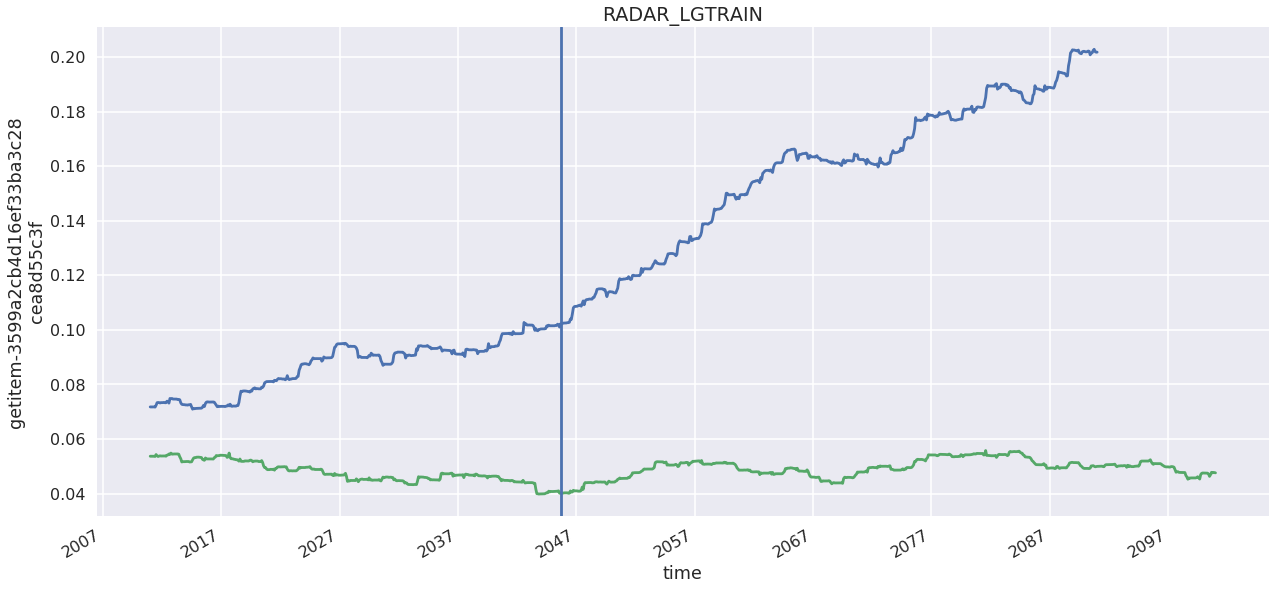

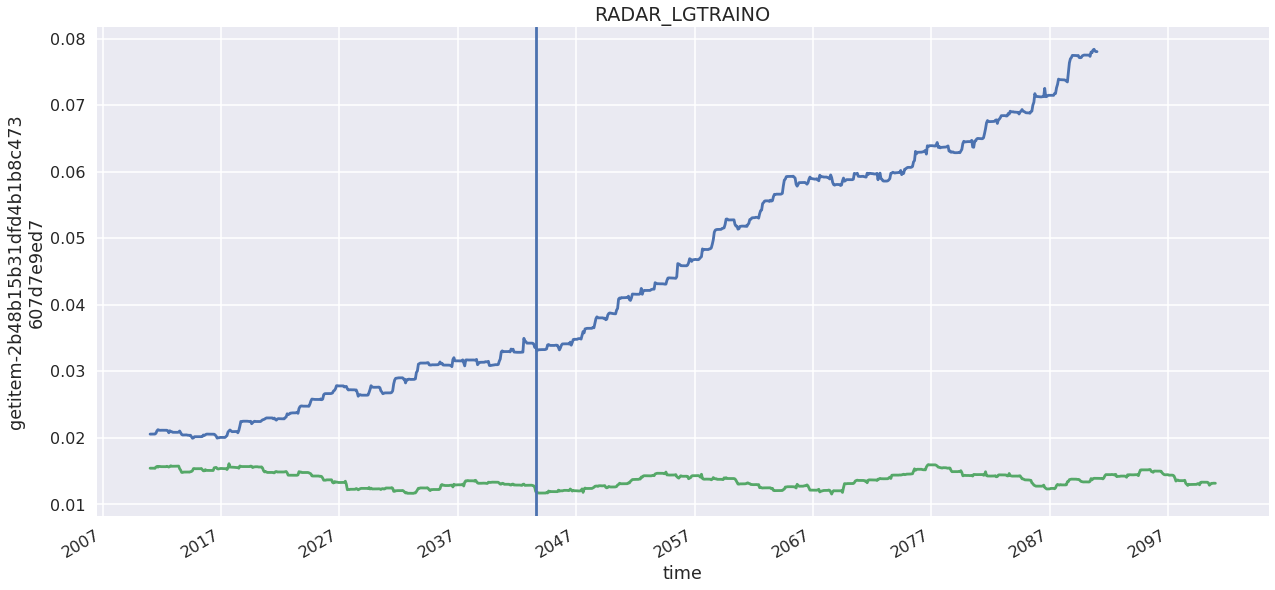

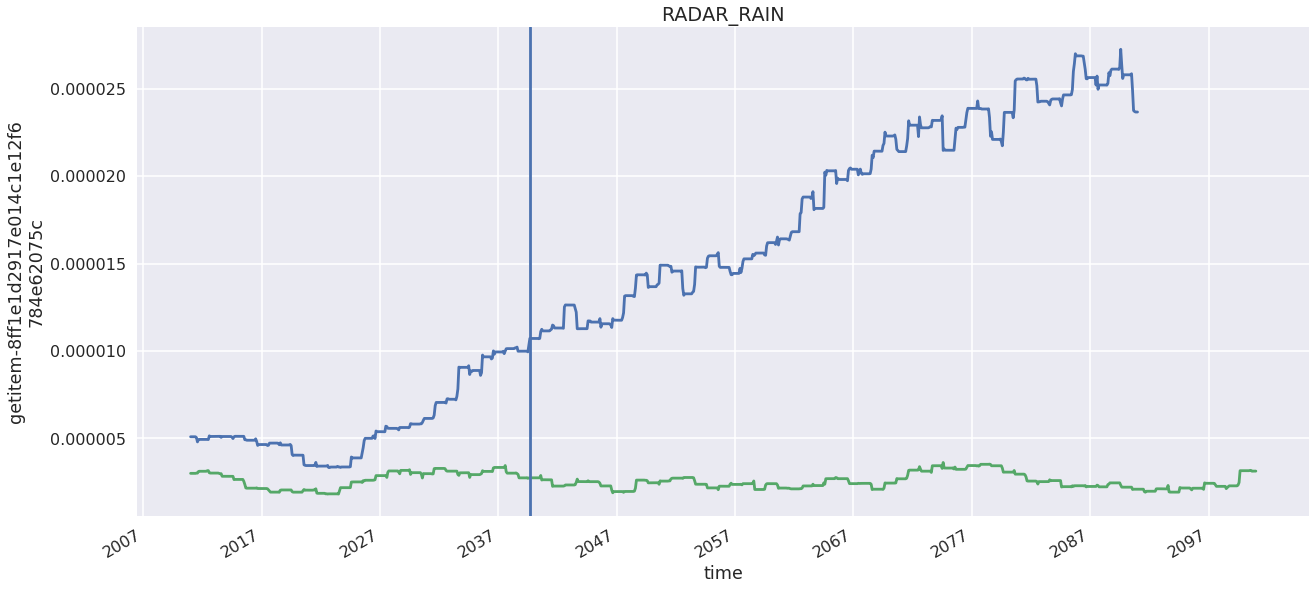

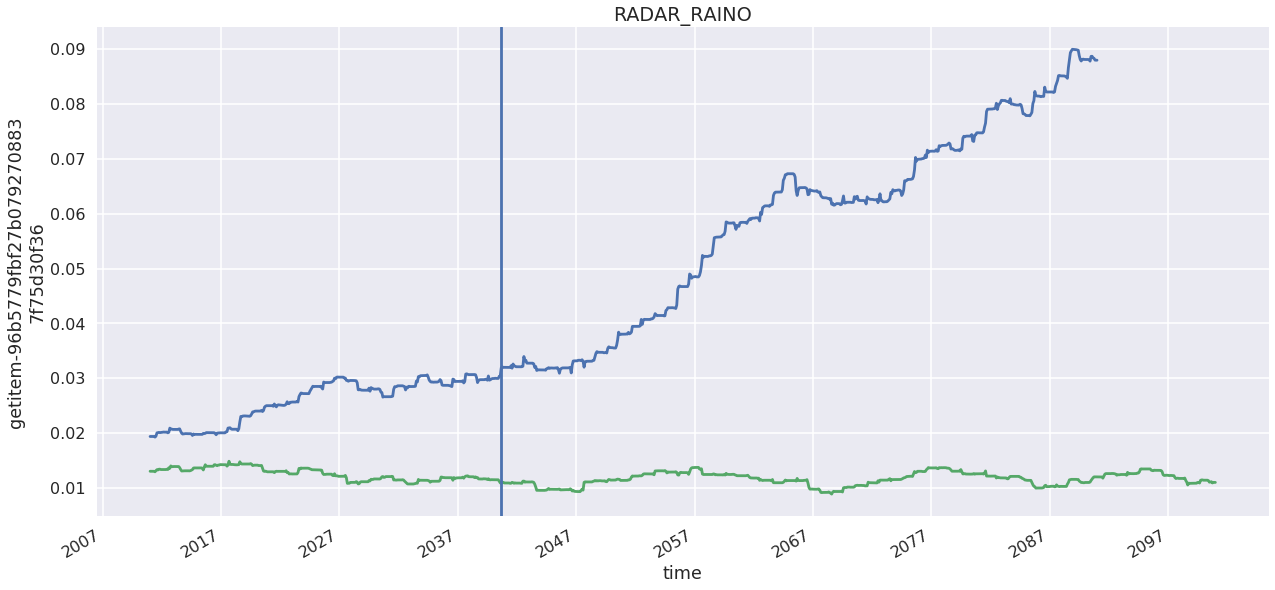

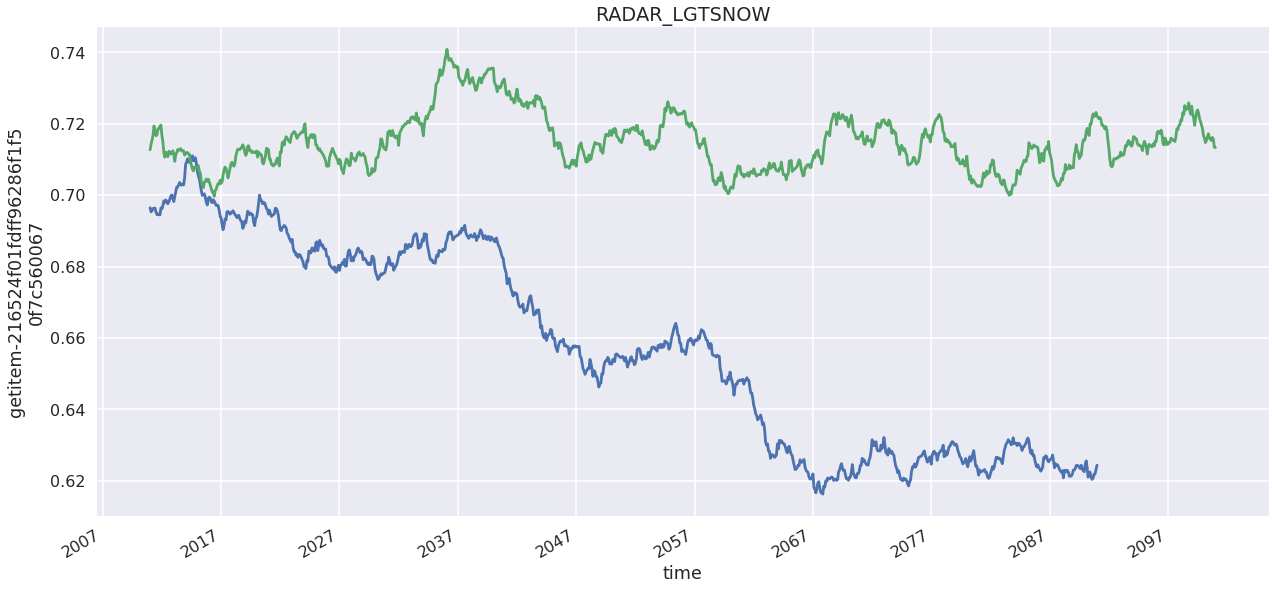

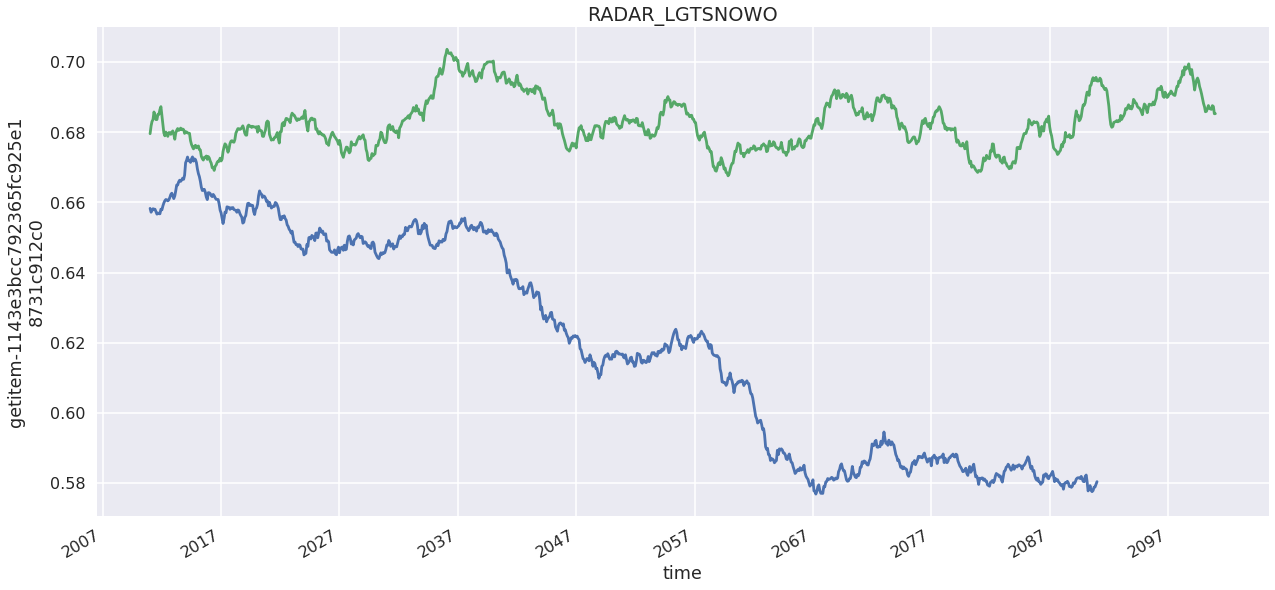

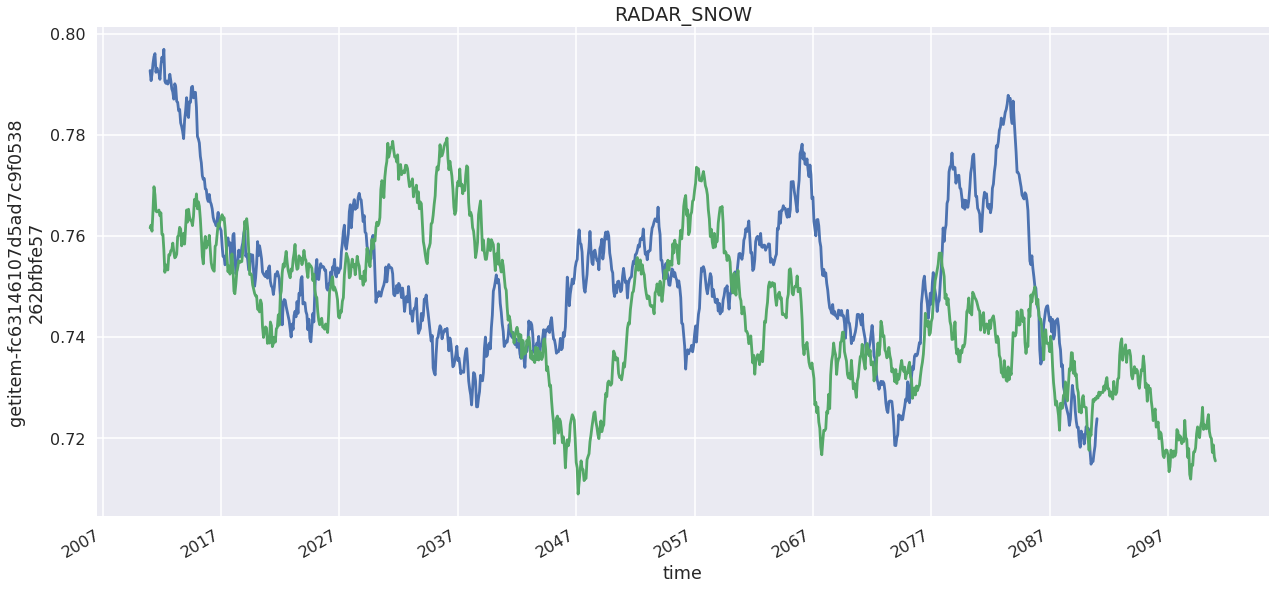

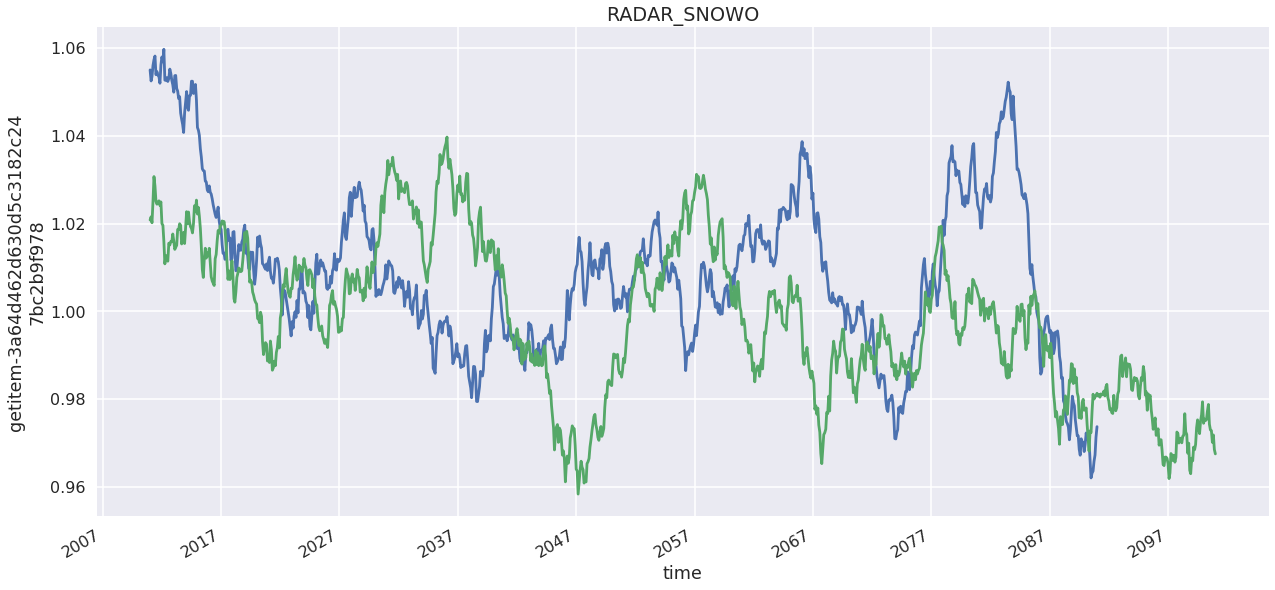

In [5]:
for var in ds_vars:

    f, ax = plt.subplots(figsize=(21, 9))

    (((ds_rcp[var] * ms.values).mean('lon', skipna=True) * (ds_rcp['gw'] / 2))
     .sum('lat', skipna=True)
     .rolling(time=120, center=True)
     .mean()
     .plot(ax=ax, label='RCP8.5')
    )


    (((ds_1850[var] * ms.values).mean('lon', skipna=True) * (ds_1850['gw'] / 2))
     .sum('lat', skipna=True)
     .rolling(time=120, center=True)
     .mean()
     .plot(ax=ax, label='1850CTL')
    )
    
    ds_1850[var]
    
    emerg = np.where(
                    (abs((ds_rcp[var] * ms.values).mean('lon', skipna=True) * (ds_rcp['gw'] / 2))
                     .sum('lat', skipna=True)
                     .rolling(time=120, center=True)
                     .mean())
                    >
                    (abs(((ds_1850[var] * ms.values).mean('lon', skipna=True) * (ds_1850['gw'] / 2))
                     .sum('lat', skipna=True)
                     .rolling(time=120, center=True)
                     .mean())
                     + 
                    (abs(((ds_1850[var] * ms.values).mean('lon', skipna=True) * (ds_1850['gw'] / 2))
                     .sum('lat', skipna=True)
                     .rolling(time=120, center=True)
                     .reduce(np.std))))
                    )
    
    ax.autoscale(enable=True)
    
    if emerg[0].size:
        ax.axvline(x=ds_rcp['time'][emerg[0][0]].values)
    
    ax.set_title(var)
    f.savefig('../figures/fullruns/tseries/%s' % var)

### Recreating `compare`

In [6]:
ds_pres = ds_rcp.isel(time=slice(0, 180))
ds_fut = ds_rcp.isel(time=slice(-181, -1))

In [7]:
rain_pres = (
    ds_pres['RADAR_RAIN'] + ds_pres['RADAR_LGTRAIN'])
snow_pres = (
    ds_pres['RADAR_SNOW'] + ds_pres['RADAR_LGTSNOW'])

rain_fut = (
    ds_fut['RADAR_RAIN'] + ds_fut['RADAR_LGTRAIN'])
snow_fut = (
    ds_fut['RADAR_SNOW'] + ds_fut['RADAR_LGTSNOW'])

rain_obs = (
    ds_obs['raincounts'] + #ds_obs['heavyraincounts'] +
    ds_obs['probablecounts'] + ds_obs['possiblecounts'])
snow_obs = (
    ds_obs['snowcounts'] + ds_obs['snowpossiblecounts'])

In [8]:
cutoff = 10

frac_pres = rain_pres / (snow_pres + 10**-32)
frac_fut = rain_fut / (snow_fut + 10**-32)
frac_obs = rain_obs / (snow_obs + 10**-32)

fp_int = frac_pres.values
fp_int[fp_int > cutoff] = cutoff
frac_pres = xr.DataArray(fp_int, coords=frac_pres.coords)

ff_int = frac_fut.values
ff_int[ff_int > cutoff] = cutoff
frac_fut = xr.DataArray(ff_int, coords=frac_fut.coords)

fo_int = frac_obs.values
fo_int[fo_int > cutoff] = cutoff
frac_obs = xr.DataArray(fo_int, coords=frac_obs.coords)

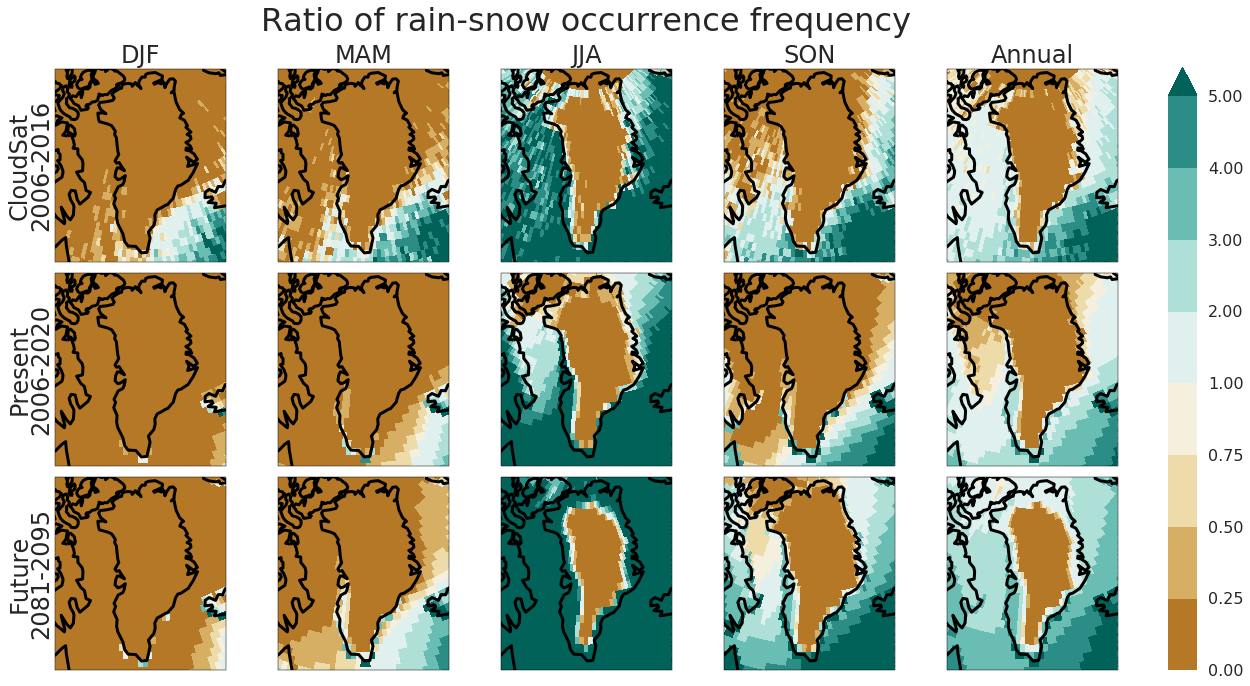

In [9]:
f, axes = plt.subplots(
    nrows=3, ncols=5, figsize=(16, 9),
    subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
)


for i, x in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    (frac_obs
     .groupby('time.season')
     .mean('time', skipna=True)
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[0, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

    (frac_pres
     .groupby('time.season')
     .mean('time', skipna=True)
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[1, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

    (frac_fut
     .groupby('time.season')
     .mean('time', skipna=True)
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[2, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

    axes[0, i].set_title(x, fontsize=24)
    

p = (frac_obs
     .mean('time', skipna=True)
     .plot.pcolormesh(
         ax=axes[0, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
     )
    )

(frac_pres
 .mean('time', skipna=True)
 .plot.pcolormesh(
     ax=axes[1, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
 )
)

(frac_fut
 .mean('time', skipna=True)
 .plot.pcolormesh(
     ax=axes[2, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=[0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0], colors=sns.color_palette('BrBG', 10)[1:]
 )
)

axes[0, 4].set_title('Annual', fontsize=24)

for ax in axes.flat:
    ax.coastlines(linewidth=3)
    ax.set_extent([295, 335, 57, 84])


for ax, ylab, yr in zip(axes[:, 0], ['CloudSat', 'Present', 'Future'], ['2006-2016', '2006-2020', '2081-2095']):
    ax.text(-0.21, 0.5, ylab, rotation='vertical', fontsize=24,
            ha='center', va='center', transform=ax.transAxes)
    ax.text(-0.08, 0.5, yr, rotation='vertical', fontsize=24,
            ha='center', va='center', transform=ax.transAxes)

t = f.suptitle('Ratio of rain-snow occurrence frequency', y=1.04, fontsize=32)    

plt.tight_layout()

#f.subplots_adjust(right=0.8, hspace=0.0000005, wspace=0.1)
cb_ax = f.add_axes([1.005, 0.017, 0.025, 0.93])
cb = f.colorbar(p, cax=cb_ax)#, extend='neither')
#cb.set_label('', rotation=270, fontsize=24)

f.savefig('../figures/fullruns/map_grid_rain-snow-frac_LO.png',
         bbox_extra_artists=([t, cb_ax].append([ax for ax in axes[:, 0]])), bbox_inches='tight')

In [10]:
w_in = np.tile((ds_rcp['gw']), [len(ds_rcp['lon']), 1]).T
w = w_in / w_in.sum() / 2

mask = np.concatenate((msi.values[:, int(len(msi['lon']) / 2):], msi.values[:, 0:int(len(msi['lon']) / 2)]), axis=1)

x, y = np.meshgrid((msi['lon'].values - 180), msi['lat'])
xx, yy = np.meshgrid(ds_obs['longitude'], ds_obs['latitude']) 

msi_grid = geometry.GridDefinition(lons=x, lats=y)
obs_grid = geometry.GridDefinition(lons=xx, lats=yy)

msi_image = image.ImageContainerNearest(image_data=mask, geo_def=msi_grid, radius_of_influence=500000)
obs_ms = msi_image.resample(obs_grid).image_data

w_image = image.ImageContainerNearest(image_data=w, geo_def=msi_grid, radius_of_influence=100000)
obs_w = w_image.resample(obs_grid).image_data

rain_pres_w = ((rain_pres * ms.values).mean('lon') * ds_rcp['gw'] / 2).sum('lat')
snow_pres_w = ((snow_pres * ms.values).mean('lon') * ds_rcp['gw'] / 2).sum('lat')

rain_fut_w = ((rain_fut * ms.values).mean('lon') * ds_rcp['gw'] / 2).sum('lat')
snow_fut_w = ((snow_fut * ms.values).mean('lon') * ds_rcp['gw'] / 2).sum('lat')

rain_obs_w = ((rain_obs / ds_obs['counts'] * 100) * obs_ms * obs_w).sum('latitude').sum('longitude')
snow_obs_w = ((snow_obs / ds_obs['counts'] * 100) * obs_ms * obs_w).sum('latitude').sum('longitude')

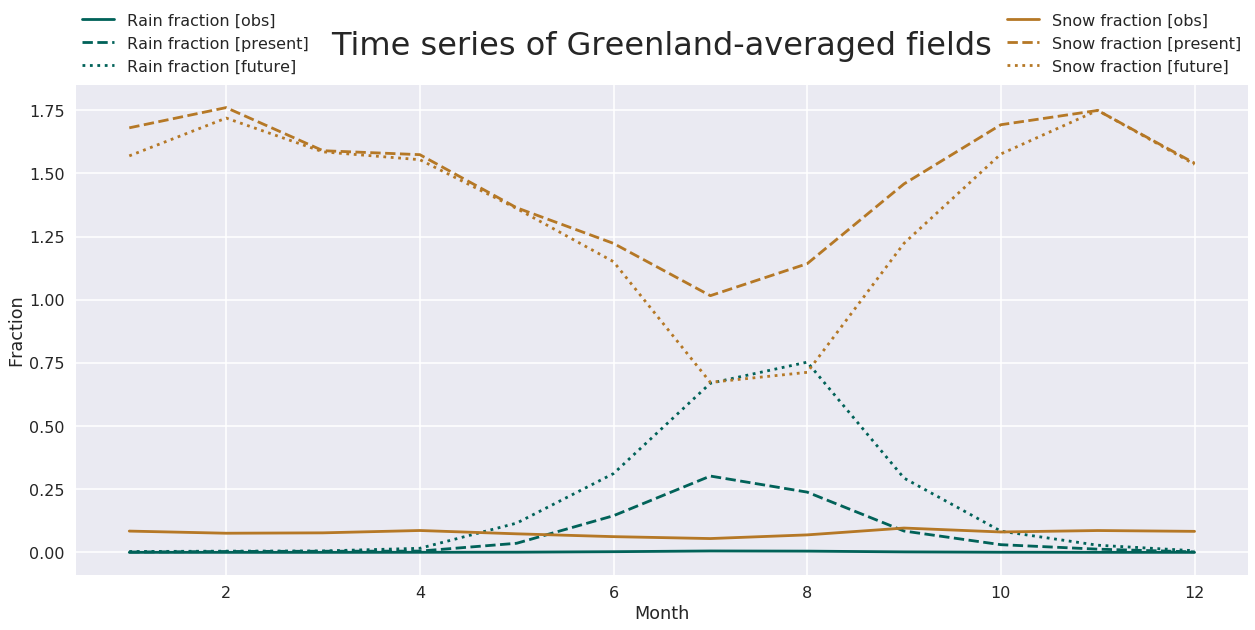

In [11]:
f, ax = plt.subplots(figsize=(21, 9))

(rain_obs_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Rain fraction [obs]'),
      color=sns.color_palette('BrBG', 10)[-1])
)

(rain_pres_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Rain fraction [present]'), linestyle='dashed',
       color=sns.color_palette('BrBG', 10)[-1])
)

(rain_fut_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Rain fraction [future]'), linestyle='dotted',
       color=sns.color_palette('BrBG', 10)[-1])
)

(snow_obs_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Snow fraction [obs]'),
      color=sns.color_palette('BrBG', 10)[1])
)

(snow_pres_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Snow fraction [present]'), linestyle='dashed',
       color=sns.color_palette('BrBG', 10)[1])
)

(snow_fut_w
 .groupby('time.month').mean('time', skipna=True)
 .plot(ax=ax, label=('Snow fraction [future]'), linestyle='dotted',
       color=sns.color_palette('BrBG', 10)[1])
)
    
ax.autoscale(enable=True)    

ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('Month')
ax.set_title('Time series of Greenland-averaged fields', y=1.05, fontsize=32)

f.savefig('../figures/fullruns/GIS-average_tseries_LO.png', bbox_inches='tight')